In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, simpson
from scipy.optimize import minimize, differential_evolution, minimize, basinhopping, brute

In [3]:
def eq_diff_voiture(t,x,d,Db,Df,b,l,meq):
    p=0.055
    Cr=3.3e-4
    k=0.092
    theta_0=4.615
    req=1/(2/Db+2/Df)
    
    theta = x[0]
    theta_d = x[1]

    x_d = theta_d
    x_dd = 1/np.sin(theta)*(-theta_d**2*np.cos(theta)+np.sqrt(b**2+l**2-2*b*l*np.cos(theta))*(theta_d**2*b*l*np.sin(theta)**2/((b**2+l**2-2*b*l*np.cos(theta))**(3/2))+d/(meq*Db*b*l)*(-k*(theta-theta_0)*d*np.sqrt(b**2+l**2-2*b*l*np.cos(theta))/(Db*b*l*np.sin(theta))-Cr/req-p*Db*b*l/d*theta_d*np.sin(theta)/(np.sqrt(b**2+l**2-2*b*l*np.cos(theta))))))

    return np.array([x_d, x_dd])

In [4]:
def solve_eq_diff_voiture(params):
    t_i ,t_f = 0, 15
    return solve_ivp(eq_diff_voiture, [t_i, t_f], [0.1, 0], args=(params['d'], params['Db'], params['Df'], params['b'], params['l'], params['meq']), t_eval=np.linspace(t_i, t_f, 50))    

def calculate_speed_from_sol(sol, params):
    theta = sol.y[0]
    theta_d = sol.y[1]

    v_1 = params['Db']/params['d']*params['b']*params['l']*theta_d*np.sin(theta)/np.sqrt(params['b']**2+params['l']**2-2*params['b']*params['l']*np.cos(theta))
    # On calcule la suite sans le ressort avec une formule explicite
    v_fin = v_1[-1]
    req = 1/(2/params['Db']+2/params['Df'])
    v_2 = v_fin-3.3e-4/(params['mc']*req)*sol.t
    # On recalcule le temps sur la phase 1 pour le concaténer avec la phase 2
    t = np.linspace(0, sol.t[-1]*2, len(v_1)*2)
    # On renvoie la position, la vitesse en phase 1 concaténée avec la vitesse en phase 2 et le temps
    return np.concatenate((v_1, v_2)), t

def calculate_time_to_reach_length(v, t, length):
    # On calcule la distance parcourue à chaque instant
    distance = np.zeros(len(t))
    for i in range(1, len(t)):
        distance[i] = simpson(v[:i], t[:i])
    # On cherche l'indice du premier instant où la distance parcourue est supérieure à la longueur de la piste
    to = t[np.argmax(distance > length)]
    if to == 0:
        return np.inf
    return to

    

def plot_speed(v, t):
    plt.plot(t, v)
    plt.xlabel('Temps (s)')
    plt.ylabel('Vitesse (m/s)')
    plt.show()

  message: 'Required step size is less than spacing between numbers.'
     nfev: 644
     njev: 0
      nlu: 0
      sol: None
   status: -1
  success: False
        t: array([0.        , 0.30612245, 0.6122449 , 0.91836735, 1.2244898 ,
       1.53061224, 1.83673469, 2.14285714, 2.44897959, 2.75510204,
       3.06122449, 3.36734694, 3.67346939, 3.97959184, 4.28571429,
       4.59183673, 4.89795918, 5.20408163, 5.51020408, 5.81632653,
       6.12244898, 6.42857143, 6.73469388, 7.04081633])
 t_events: None
        y: array([[0.1       , 0.11744259, 0.15845434, 0.21120491, 0.27139307,
        0.33748319, 0.40876145, 0.48476782, 0.5651947 , 0.64985975,
        0.73862575, 0.83148913, 0.92859645, 1.0302444 , 1.13687983,
        1.24910309, 1.36784666, 1.49452225, 1.63123318, 1.78114967,
        1.94987348, 2.14793183, 2.40120682, 2.83945313],
       [0.        , 0.10465846, 0.15692841, 0.18569838, 0.20676855,
        0.22467687, 0.24075755, 0.25563372, 0.26970102, 0.28331313,
        0.29674

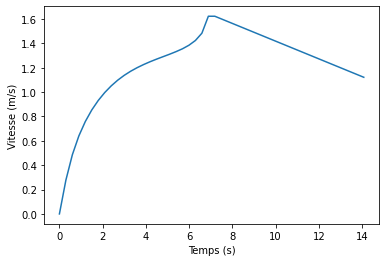

In [5]:
fixed_params = {
    'meq': 0.1634,  # masse+ moments d'inerties
    'mc': 0.1546,  # masse véhicule
}

params_var_test = {
    'd': 0.01,
    'Db': 2 * 0.075,
    'Df': 2 * 0.05,
    'b': 0.3,
    'l': 0.26,
}

params_test = {**fixed_params, **params_var_test}

sol = solve_eq_diff_voiture(params_test)
print(sol)
print(len(sol.t))
v, t = calculate_speed_from_sol(sol, params_test)
print(calculate_time_to_reach_length(v, t, 15))
plot_speed(v, t)


In [6]:
# Maintenant on cherche les paramètres optimaux pour atteindre 15m en le moins de temps possible
bounds = [
    (3e-3, 0.1),  # d
    (0.03, 0.3),  # Db
    (0.03, 0.3),  # Df
    (0.03, 1),  # b
    (0.03, 1),  # l
]

def objective(X):
    # Concatenate fixed and variable parameters
    params = {
        'd': X[0],
        'Db': X[1],
        'Df': X[2],
        'b': X[3],
        'l': X[4],
        **fixed_params
    }
    sol = solve_eq_diff_voiture(params)
    v, t = calculate_speed_from_sol(sol, params)
    return calculate_time_to_reach_length(v, t, 15)

def find_optimal_params():
    def callback(x, convergence):
        print(f'x: {x}, convergence: {convergence}')

    x0 = params_var_test.values()
    return differential_evolution(objective, bounds=bounds, maxiter=10, callback=callback, disp=True, workers=-1, updating='deferred')

opt = find_optimal_params()
print(opt)

# On peut maintenant afficher la vitesse en fonction du temps pour les paramètres optimaux
optimal_params = {
    'd': opt.x[0],
    'Db': opt.x[1],
    'Df': opt.x[2],
    'b': opt.x[3],
    'l': opt.x[4],
    **fixed_params
}

sol = solve_eq_diff_voiture(optimal_params)
v, t = calculate_speed_from_sol(sol, optimal_params)
plot_speed(v, t)
print(calculate_time_to_reach_length(v, t, 15))


In [ ]:
calculate_time_to_reach_length(v, t, 15)
#Print optimal parameters
print(optimal_params)

{'d': 0.04444745230807337, 'Db': 0.2186095130510126, 'Df': 0.2809241818525379, 'b': 0.6121161731920443, 'l': 0.622318051568829, 'meq': 0.1634, 'mc': 0.1546}
